In [1]:
import numpy as np
import random
from collections import defaultdict, deque
from tqdm import trange  # progress bar (install with pip if missing)
import matplotlib.pyplot as plt

In [2]:
# Environment: Tic-Tac-Toe

class TicTacToe:
    def __init__(self):
        # board cells: 0 = empty, 1 = player1 (agent), 2 = player2 (opponent)
        self.board = np.zeros(9, dtype=int)
        self.current_player = 1  # 1 starts by default

    def reset(self, start_player=1):
        self.board[:] = 0
        self.current_player = start_player
        return self.get_state()

    def get_state(self):
        # return a tuple view of board for hashability
        return tuple(self.board.tolist())

    def available_actions(self):
        return [i for i in range(9) if self.board[i] == 0]

    def step(self, action):
        """
        Apply action for current_player.
        Returns: next_state, reward, done, info
        reward: given from perspective of player who just played (must be interpreted by caller)
        """
        assert self.board[action] == 0, "Invalid action"
        self.board[action] = self.current_player

        winner = self.check_winner()
        done = winner is not None or not any(self.board == 0)

        if done:
            if winner == 1:
                reward = 1  # player1 (agent) wins
            elif winner == 2:
                reward = -1  # player1 loses
            else:
                reward = 0  # draw
        else:
            reward = 0

        info = {"winner": winner}
        # switch player for next turn
        self.current_player = 1 if self.current_player == 2 else 2
        return self.get_state(), reward, done, info

    def check_winner(self):
        b = self.board.reshape(3,3)
        lines = []

        # rows, cols
        lines.extend([b[i, :] for i in range(3)])
        lines.extend([b[:, j] for j in range(3)])
        # diagonals
        lines.append(np.array([b[i,i] for i in range(3)]))
        lines.append(np.array([b[i,2-i] for i in range(3)]))

        for line in lines:
            if np.all(line == 1):
                return 1
            if np.all(line == 2):
                return 2

        if not any(self.board == 0):
            return 0  # draw

        return None  # game ongoing

    def render(self):
        sym = {0:'.', 1:'X', 2:'O'}
        b = [sym[x] for x in self.board]
        print(f"{b[0]} {b[1]} {b[2]}")
        print(f"{b[3]} {b[4]} {b[5]}")
        print(f"{b[6]} {b[7]} {b[8]}")
        print()

In [3]:
# Q-Learning Agent (tabular)

class QLearningAgent:
    def __init__(self, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9995):
        """
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration prob
        """
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Q-table: maps (state tuple) -> array of length 9 (Q-values for each action)
        # We'll lazily initialize Q entries to zero arrays
        self.Q = defaultdict(lambda: np.zeros(9, dtype=float))

    def state_action_values(self, state):
        return self.Q[state]

    def choose_action(self, state, available_actions):
        """
        Epsilon-greedy selection among available actions.
        """
        if random.random() < self.epsilon:
            return random.choice(available_actions)
        q_vals = self.state_action_values(state)
        # pick best among available (break ties randomly)
        best_q = -np.inf
        best_actions = []
        for a in available_actions:
            val = q_vals[a]
            if val > best_q:
                best_q = val
                best_actions = [a]
            elif val == best_q:
                best_actions.append(a)
        return random.choice(best_actions)

    def update(self, state, action, reward, next_state, next_available_actions, done):
        """
        Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
        If done -> target = r (no future)
        """
        q_sa = self.Q[state][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state][next_available_actions]) if next_available_actions else reward
        self.Q[state][action] = q_sa + self.alpha * (target - q_sa)

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

    def save_policy(self, filename):
        import pickle
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.Q), f)

    def load_policy(self, filename):
        import pickle
        with open(filename, 'rb') as f:
            qdict = pickle.load(f)
        self.Q = defaultdict(lambda: np.zeros(9, dtype=float), qdict)

In [4]:
# Training loop

def train(agent, env, episodes=20000, verbose_interval=2000):
    stats = {"win":0, "loss":0, "draw":0}
    history = deque(maxlen=episodes)

    for ep in trange(episodes, desc="Training"):
        state = env.reset(start_player=1)  # agent plays as player 1 (X)
        done = False

        while not done:
            if env.current_player == 1:
                # agent's turn
                avail = env.available_actions()
                action = agent.choose_action(state, avail)
                next_state, reward, done, info = env.step(action)

                # If the game ended right after agent move:
                if done:
                    agent.update(state, action, reward, next_state, [], done)
                    # record result from agent perspective
                    if reward == 1:
                        stats["win"] += 1
                    elif reward == -1:
                        stats["loss"] += 1
                    else:
                        stats["draw"] += 1
                    break
                else:
                    # opponent will play next; get next available actions (before opponent move)
                    next_avail = env.available_actions()
                    # temporarily update with reward 0 (non-terminal)
                    agent.update(state, action, 0, next_state, next_avail, False)
                    state = next_state
            else:
                # opponent (random) plays
                avail = env.available_actions()
                opp_action = random.choice(avail)
                next_state, reward, done, info = env.step(opp_action)

                if done:
                    # reward from perspective of player1 (agent) is already set in step()
                    # If opponent just finished the game, reward will be -1 for agent on loss
                    # But since agent didn't play this move, we must update last agent's state-action with this terminal reward
                    # To do that, we need to find previous state/action pair; simplified approach:
                    # We'll not update here because agent's last update will be done when agent played.
                    # Instead, we can attribute the terminal signal to the previous agent move by backtracking if necessary.
                    # For simplicity, we won't perform complex backprop here.
                    # Stats update:
                    if reward == 1:
                        stats["win"] += 1
                    elif reward == -1:
                        stats["loss"] += 1
                    else:
                        stats["draw"] += 1
                    break
                else:
                    state = next_state

        # record history occasionally
        history.append((stats["win"], stats["loss"], stats["draw"]))
        if (ep+1) % verbose_interval == 0:
            w,l,d = stats["win"], stats["loss"], stats["draw"]
            print(f"\nEpisode {ep+1}: wins={w}, losses={l}, draws={d}, epsilon={agent.epsilon:.4f}")

    return history, stats

In [5]:
# Evaluation (vs Random)

def evaluate(agent, env, episodes=2000):
    wins = losses = draws = 0
    # temporarily make policy deterministic (epsilon=0)
    old_eps = agent.epsilon
    agent.epsilon = 0.0

    for _ in range(episodes):
        state = env.reset(start_player=1)
        done = False
        while not done:
            if env.current_player == 1:
                action = agent.choose_action(state, env.available_actions())
                next_state, reward, done, info = env.step(action)
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1
                    break
                else:
                    state = next_state
            else:
                # random opponent
                action = random.choice(env.available_actions())
                next_state, reward, done, info = env.step(action)
                if done:
                    if reward == 1:
                        wins += 1
                    elif reward == -1:
                        losses += 1
                    else:
                        draws += 1
                    break
                else:
                    state = next_state

    agent.epsilon = old_eps
    return {"wins": wins, "losses": losses, "draws": draws}

Training:  21%|█████████████▌                                                   | 5210/25000 [00:04<00:16, 1186.51it/s]


Episode 5000: wins=3405, losses=1098, draws=497, epsilon=0.0100


Training:  40%|█████████████████████████▉                                      | 10116/25000 [00:08<00:12, 1210.72it/s]


Episode 10000: wins=7278, losses=1823, draws=899, epsilon=0.0100


Training:  61%|██████████████████████████████████████▊                         | 15160/25000 [00:12<00:07, 1278.65it/s]


Episode 15000: wins=11289, losses=2451, draws=1260, epsilon=0.0100


Training:  81%|███████████████████████████████████████████████████▌            | 20128/25000 [00:16<00:03, 1259.06it/s]


Episode 20000: wins=15311, losses=3098, draws=1591, epsilon=0.0100


Training: 100%|████████████████████████████████████████████████████████████████| 25000/25000 [00:19<00:00, 1250.21it/s]



Episode 25000: wins=19373, losses=3712, draws=1915, epsilon=0.0100

Evaluation vs Random (2000 games):
Wins: 1635 (81.75%)
Losses: 238 (11.90%)
Draws: 127 (6.35%)


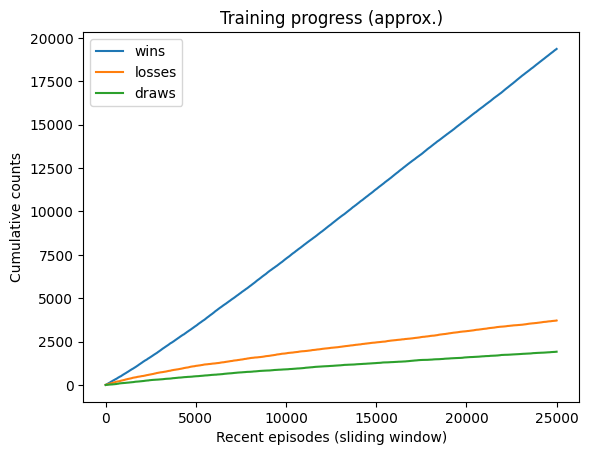

In [6]:
# Run training and evaluation

if __name__ == "__main__":
    env = TicTacToe()
    agent = QLearningAgent(alpha=0.8, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)

    # Train
    history, stats = train(agent, env, episodes=25000, verbose_interval=5000)

    # Evaluate agent performance vs random opponent
    results = evaluate(agent, env, episodes=2000)
    total = results["wins"] + results["losses"] + results["draws"]
    print("\nEvaluation vs Random (2000 games):")
    print(f"Wins: {results['wins']} ({results['wins']/total*100:.2f}%)")
    print(f"Losses: {results['losses']} ({results['losses']/total*100:.2f}%)")
    print(f"Draws: {results['draws']} ({results['draws']/total*100:.2f}%)")

    # Plot win/loss/draw trend during training if you saved history points
    # Simple approximation: plot running totals (history deque)
    wins = [h[0] for h in history]
    losses = [h[1] for h in history]
    draws = [h[2] for h in history]
    plt.plot(wins, label='wins')
    plt.plot(losses, label='losses')
    plt.plot(draws, label='draws')
    plt.legend()
    plt.xlabel('Recent episodes (sliding window)')
    plt.ylabel('Cumulative counts')
    plt.title('Training progress (approx.)')
    plt.show()